<a href="https://colab.research.google.com/github/ES078/Data-Science-Portfolio/blob/main/2024_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data and import libraries that we need

Version of this jupyter notebook: sentimentanalysis_V2.4

In [ ]:
# Define where we will download the data
path_data = "/content/sample_data"

Download the data

In [ ]:
!wget -P /content/sample_data/ -c "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

--2024-12-03 15:27:26--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Decompress the archive

In [ ]:
!tar -xf  /content/sample_data/aclImdb_v1.tar.gz -C /content/sample_data/

Check that the folder aclImdb exists

In [ ]:
!ls /content/sample_data/

aclImdb		   anscombe.json		california_housing_train.csv  mnist_train_small.csv
aclImdb_v1.tar.gz  california_housing_test.csv	mnist_test.csv		      README.md


Import all required libraries

In [ ]:
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
from gensim.models import Word2Vec, Phrases
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import pad_sequences

Define function that reads all the files from a given folder

In [ ]:
def read_data(path, files):
    data = []
    for f in files:
        with open(path + f) as file:
            ### BEGIN YOUR CODE HERE
            line = file.readline()
            data.append(line)
            ### END YOUR CODE HERE
    return data

Load data (movie reviews), both for train and test

In [ ]:
path_data_train_pos = path_data + '/aclImdb/train/pos/'
path_data_train_neg = path_data + '/aclImdb/train/neg/'
path_data_test_pos = path_data + '/aclImdb/test/pos/'
path_data_test_neg = path_data + '/aclImdb/test/neg/'

# Get the list of files from the four folders
train_pos_files = os.listdir(path_data_train_pos)
train_neg_files = os.listdir(path_data_train_neg)
test_pos_files = os.listdir(path_data_test_pos)
test_neg_files = os.listdir(path_data_test_neg)

In [ ]:
### BEGIN YOUR CODE HERE

# Read the data using the read_data() function
train_data_pos = read_data(path_data_train_pos, train_pos_files)
train_data_neg = read_data(path_data_train_neg, train_neg_files)
test_data_pos = read_data(path_data_test_pos, test_pos_files)
test_data_neg = read_data(path_data_test_neg, test_neg_files)

# 1a. How many examples do we have in training for positive reviews? How many for negative reviews?
num_train_pos = len(train_data_pos)
num_train_neg = len(train_data_neg)

print(f"Number of positive reviews in training set: {num_train_pos}")
print(f"Number of negative reviews in training set: {num_train_neg}")

# 1b. How many examples do we have in the testing set?
num_test_pos = len(test_data_pos)
num_test_neg = len(test_data_neg)

print(f"Number of positive reviews in testing set: {num_test_pos}")
print(f"Number of negative reviews in testing set: {num_test_neg}")

# 1c. Is the dataset balanced or not?
if num_train_pos == num_train_neg and num_test_pos == num_test_neg:
    print("The dataset is balanced.")
else:
    print("The dataset is not balanced.")

# 2. Print examples of positive and negative reviews from training and testing datasets
print("\nExample of a positive review from training set:")
print(train_data_pos[0] if train_data_pos else "No data available")

print("\nExample of a negative review from training set:")
print(train_data_neg[0] if train_data_neg else "No data available")

print("\nExample of a positive review from testing set:")
print(test_data_pos[0] if test_data_pos else "No data available")

print("\nExample of a negative review from testing set:")
print(test_data_neg[0] if test_data_neg else "No data available")

### END YOUR CODE HERE

Number of positive reviews in training set: 12500
Number of negative reviews in training set: 12500
Number of positive reviews in testing set: 12500
Number of negative reviews in testing set: 12500
The dataset is balanced.

Example of a positive review from training set:
Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The movie is nea

In [ ]:
# Toggle between using a subset or the full dataset
use_full_dataset = False # Set to False if you want to test with a smaller subset

if use_full_dataset:
    sample_number = len(train_data_pos)  # Use the full length of the dataset
else:
    sample_number = 2000 # Use a subset for faster testing

# Use only the first `sample_number` reviews from each dataset
train_data_pos = train_data_pos[:sample_number]
train_data_neg = train_data_neg[:sample_number]
test_data_pos = test_data_pos[:sample_number]
test_data_neg = test_data_neg[:sample_number]

# Print the number of samples being used for quick verification
print(f"Using {sample_number} samples for each category:")
print(f"Train positive reviews: {len(train_data_pos)}")
print(f"Train negative reviews: {len(train_data_neg)}")
print(f"Test positive reviews: {len(test_data_pos)}")
print(f"Test negative reviews: {len(test_data_neg)}")

Using 2000 samples for each category:
Train positive reviews: 2000
Train negative reviews: 2000
Test positive reviews: 2000
Test negative reviews: 2000


Create the data structures that we'll use for training and testing

In [ ]:
### BEGIN YOUR CODE HERE
# Assign the length of the train_data_pos to variable length_train_pos
length_train_pos = len(train_data_pos)

# Assign the length of the train_data_neg to variable length_train_neg
length_train_neg = len(train_data_neg)

# Assign the length of the test_data_pos to variable length_test_pos
length_test_pos = len(test_data_pos)

# Assign the length of the test_data_neg to variable length_test_neg
length_test_neg = len(test_data_neg)
### END YOUR CODE HERE

# Print the lengths for verification
print("Length of the positive training examples is", length_train_pos)
print("Length of the negative training examples is", length_train_neg)
print("Length of the positive testing examples is", length_test_pos)
print("Length of the negative testing examples is", length_test_neg)

Length of the positive training examples is 2000
Length of the negative training examples is 2000
Length of the positive testing examples is 2000
Length of the negative testing examples is 2000


In [ ]:
import pandas as pd

# Create the training DataFrame with examples and labels
# Concatenate positive and negative training examples, then pair each example with a label: 1 for positive, 0 for negative
data_train = pd.DataFrame(
    zip(train_data_pos + train_data_neg, [1] * length_train_pos + [0] * length_train_neg),
    columns=['review', 'label']
)

# Create the test DataFrame with examples and labels
# Concatenate positive and negative test examples, then pair each example with a label: 1 for positive, 0 for negative
data_test = pd.DataFrame(
    zip(test_data_pos + test_data_neg, [1] * length_test_pos + [0] * length_test_neg),
    columns=['review', 'label']
)

# Combine all reviews into a single list (training + test, positive + negative)
all_reviews = train_data_pos + train_data_neg + test_data_pos + test_data_neg

# Print the shapes of the dataframes to confirm sizes
print(f"Training DataFrame shape: {data_train.shape}")
print(f"Test DataFrame shape: {data_test.shape}")

# Display the first few rows of the training and test DataFrames for verification
print("\nTraining DataFrame sample:")
print(data_train.head())

print("\nTest DataFrame sample:")
print(data_test.head())


Training DataFrame shape: (4000, 2)
Test DataFrame shape: (4000, 2)

Training DataFrame sample:
                                              review  label
0  Bizarre horror movie filled with famous faces ...      1
1  Well made and stylish while still ultimately m...      1
2  Gojoe is part of a new wave of Japanese cinema...      1
3  I watched this in July and even with the Chris...      1
4  More a snapshot of the most popular pinup of a...      1

Test DataFrame sample:
                                              review  label
0  I rented this movie for two reasons. The first...      1
1  Watching this movie, I can't help drawing the ...      1
2  A good entertainment but nothing more : in thi...      1
3  There was nothing else on tv yesterday afterno...      1
4  You will be able to tell within the first 30 s...      1


In [ ]:
print("The length of the train reviews is",len(data_train))
print("The length of the test reviews is",len(data_test))
print("The length of all reviews is",len(all_reviews))

The length of the train reviews is 4000
The length of the test reviews is 4000
The length of all reviews is 8000


## The following are functions for preprocessing text

In [ ]:
# Download stopwords and wordnet vectors
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english"))
# Declare the lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
REPLACE_WITH_SPACE = re.compile(r"[^a-zA-Z]")

# Global counter for tracking progress (used in the preprocess function)
counter = 0

# Function 1: Clean Review
def clean_review(raw_review: str) -> str:

    # 1. Remove HTML tags using BeautifulSoup
    review_text = BeautifulSoup(str(raw_review), "lxml").get_text()

    # 2. Remove non-letter characters (anything that's not A-Z or a-z)
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)

    # 3. Convert to lowercase
    lowercase_letters = letters_only.lower()

    return lowercase_letters

# Function 2: Lemmatize and Remove Stopwords
def lemmatize(tokens: list) -> list:

    # 1. Lemmatize words as nouns
    tokens = list(map(lemmatizer.lemmatize, tokens))

    # 2. Further lemmatize words as verbs
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))

    # 3. Remove stopwords
    meaningful_words = list(filter(lambda x: x not in stop_words, lemmatized_tokens))

    return meaningful_words


# Function 3: Full Preprocessing Pipeline
def preprocess(review: str, total: int, show_progress: bool = True) -> list:

    global counter

    # Display progress
    if show_progress:
        counter += 1
        print('Processing... %6i/%6i' % (counter, total), end='\r')

    # 1. Clean the text
    cleaned_review = clean_review(review)

    # 2. Tokenize the cleaned review into individual words
    tokens = word_tokenize(cleaned_review)

    # 3. Lemmatize tokens and remove stopwords
    lemmas = lemmatize(tokens)

    # 4. Return the processed tokens (list of meaningful words)
    return lemmas

## Preprocess the text of the reviews by removing the non-word characters, converting everything to lower case, and lemmatizing words


In [ ]:
import nltk

# Download all NLTK data
nltk.download('all')

# Step 1: Display the first review text from the training data
print("### Raw Review Text ###")
first_review_text = data_train['review'][0]
print(first_review_text)

# Step 2: Display the label associated with the first review
print("\n### Review Label ###")
first_review_label = data_train['label'][0]
print(f"Label: {first_review_label} (1 for positive, 0 for negative)")

# Step 3: Display the preprocessed text of the first review
print("\n### Preprocessed Review Text ###")
preprocessed_review = preprocess(first_review_text, total=1)
print(preprocessed_review)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

### Raw Review Text ###
Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The movie is nearly a cross-pollination of "Rosemary's Baby" and "The Exorcist"--but what a combination! Based on the best-seller by Jeffrey Konvitz, "The Sentinel" is entertainingly spooky, full of shocks brought off well by director Michael Winner, who mounts a 

[nltk_data]    |   Package wordnet2022 is already up-to-date!
[nltk_data]    | Downloading package wordnet31 to /root/nltk_data...
[nltk_data]    |   Package wordnet31 is already up-to-date!
[nltk_data]    | Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to /root/nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package ycoe to /root/nltk_data...
[nltk_data]    |   Package ycoe is already up-to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection all


Let's preproces the entire set of reviews

In [ ]:
# Preprocessing each review in the all_reviews list.
print("### Preprocessing all reviews ###")
counter = 0
all_reviews_preprocessed = [preprocess(x, total=len(all_reviews)) for x in all_reviews]

# Display sample of the preprocessed reviews
print("\n### Sample Preprocessed Reviews ###")
for i in range(3):
    print(f"Review {i + 1}: {all_reviews_preprocessed[i]}")


### Preprocessing all reviews ###


<ipython-input-51-cbe43f4c6ab2>:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(str(raw_review), "lxml").get_text()


Processing...   8000/  8000
### Sample Preprocessed Reviews ###
Review 1: ['bizarre', 'horror', 'movie', 'fill', 'famous', 'face', 'steal', 'cristina', 'rain', 'later', 'tv', 'flamingo', 'road', 'pretty', 'somewhat', 'unstable', 'model', 'gummy', 'smile', 'slat', 'pay', 'attempt', 'suicide', 'guard', 'gateway', 'hell', 'scene', 'rain', 'model', 'well', 'capture', 'mood', 'music', 'perfect', 'deborah', 'raffin', 'charm', 'cristina', 'pal', 'rain', 'move', 'creepy', 'brooklyn', 'height', 'brownstone', 'inhabit', 'blind', 'priest', 'top', 'floor', 'thing', 'really', 'start', 'cook', 'neighbor', 'include', 'fantastically', 'wicked', 'burgess', 'meredith', 'kinky', 'couple', 'sylvia', 'mile', 'beverly', 'angelo', 'diabolical', 'lot', 'eli', 'wallach', 'great', 'fun', 'wily', 'police', 'detective', 'movie', 'nearly', 'cross', 'pollination', 'rosemary', 'baby', 'exorcist', 'combination', 'base', 'best', 'seller', 'jeffrey', 'konvitz', 'sentinel', 'entertainingly', 'spooky', 'full', 'shock', '

In [ ]:
num_train = len(train_data_pos) + len(train_data_neg)

# Slice preprocessed reviews to get only the training set portion
X_train_preprocessed = all_reviews_preprocessed[:num_train]

# Slice preprocessed reviews to get only the testing set portion
X_test_preprocessed = all_reviews_preprocessed[num_train:]

# Print the length of each training example to verify
print(f"Number of training examples (preprocessed): {len(X_train_preprocessed)}")
print(f"Number of testing examples (preprocessed): {len(X_test_preprocessed)}")

print("\n### Sample Preprocessed Training Review ###")
print(X_train_preprocessed[:2])

print("\n### Sample Preprocessed Testing Review ###")
print(X_test_preprocessed[:2])

Number of training examples (preprocessed): 4000
Number of testing examples (preprocessed): 4000

### Sample Preprocessed Training Review ###
[['bizarre', 'horror', 'movie', 'fill', 'famous', 'face', 'steal', 'cristina', 'rain', 'later', 'tv', 'flamingo', 'road', 'pretty', 'somewhat', 'unstable', 'model', 'gummy', 'smile', 'slat', 'pay', 'attempt', 'suicide', 'guard', 'gateway', 'hell', 'scene', 'rain', 'model', 'well', 'capture', 'mood', 'music', 'perfect', 'deborah', 'raffin', 'charm', 'cristina', 'pal', 'rain', 'move', 'creepy', 'brooklyn', 'height', 'brownstone', 'inhabit', 'blind', 'priest', 'top', 'floor', 'thing', 'really', 'start', 'cook', 'neighbor', 'include', 'fantastically', 'wicked', 'burgess', 'meredith', 'kinky', 'couple', 'sylvia', 'mile', 'beverly', 'angelo', 'diabolical', 'lot', 'eli', 'wallach', 'great', 'fun', 'wily', 'police', 'detective', 'movie', 'nearly', 'cross', 'pollination', 'rosemary', 'baby', 'exorcist', 'combination', 'base', 'best', 'seller', 'jeffrey', 

In [ ]:
len(train_data_pos)

2000

In [ ]:
# Let's see how many reviews we have in total for training
# We should get 2000 if you kept the sample_number=1000
# print(X_train_preprocessed.shape)
print(len(X_train_preprocessed))

4000


## Compute Word2Vec vectors on all reviews

In [ ]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

print("### Compute Phrases Begin ###")

# Compute bigrams from all preprocessed reviews
bigrams_model = Phrases(sentences=all_reviews_preprocessed, min_count=5, threshold=10)
bigrams = Phraser(bigrams_model)

# Transform all reviews to include detected bigrams
all_reviews_bigrams = [bigrams[review] for review in all_reviews_preprocessed]

# Compute trigrams based on the bigrams output
trigrams_model = Phrases(sentences=all_reviews_bigrams, min_count=3, threshold=5)
trigrams = Phraser(trigrams_model)

# Transform all reviews to include detected trigrams
all_reviews_trigrams = [trigrams[review] for review in all_reviews_bigrams]

print("### Compute Phrases End ###")

print("\n### Sample Review with Bigrams ###")
print(all_reviews_bigrams[0])

print("\n### Sample Review with Trigrams ###")
print(all_reviews_trigrams[0])

### Compute Phrases Begin ###
### Compute Phrases End ###

### Sample Review with Bigrams ###
['bizarre', 'horror', 'movie', 'fill', 'famous', 'face', 'steal', 'cristina_rain', 'later', 'tv', 'flamingo', 'road', 'pretty', 'somewhat', 'unstable', 'model', 'gummy', 'smile', 'slat', 'pay', 'attempt', 'suicide', 'guard', 'gateway', 'hell', 'scene', 'rain', 'model', 'well', 'capture', 'mood', 'music', 'perfect', 'deborah', 'raffin', 'charm', 'cristina', 'pal', 'rain', 'move', 'creepy', 'brooklyn', 'height', 'brownstone', 'inhabit', 'blind', 'priest', 'top', 'floor', 'thing', 'really', 'start', 'cook', 'neighbor', 'include', 'fantastically', 'wicked', 'burgess_meredith', 'kinky', 'couple', 'sylvia', 'mile', 'beverly_angelo', 'diabolical', 'lot', 'eli_wallach', 'great', 'fun', 'wily', 'police_detective', 'movie', 'nearly', 'cross', 'pollination', 'rosemary_baby', 'exorcist', 'combination', 'base', 'best_seller', 'jeffrey', 'konvitz', 'sentinel', 'entertainingly', 'spooky', 'full', 'shock', 'b

In [ ]:
# Test how our phrase looks after calling the bigrams
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar', 'system']


In [ ]:
# Test how our phrase looks after calling the trigrams
# Do you notice any difference compared with the bigrams?
print(trigrams[bigrams['space station near the solar system'.split()]])

['space_station', 'near', 'the', 'solar', 'system']


In [ ]:
print("Start learning the word embedding")
embedding_vector_size = 256
trigram_model = Word2Vec(
    sentences=all_reviews_trigrams,
    vector_size=256,
    min_count=5,
    window=5,
    workers=4,
    sg=1,
    epochs=10
)
print("Done learning")

Start learning the word embedding
Done learning


Check what is the vocabulary size

In [ ]:
print("Vocabulary size:", len(trigram_model.wv))

Vocabulary size: 17976


Let's check the most similar words for "movie" & "galaxy"

In [ ]:
trigram_model.wv.most_similar('movie')
# If you are working with the subset of 1000 reviews, the most similar words might not be
# the most relevant ones. You can remove the constraint of working with only 1000 reviews,
# and compare what are the most similar words again, but please be aware that this might
# increase the training time of the word2vec

[('sci_fi_movie', 0.6957032680511475),
 ('dark_harvest', 0.6926688551902771),
 ('foreign_film', 0.6889390349388123),
 ('definately', 0.6885450482368469),
 ('movie_sci_fi', 0.6861522793769836),
 ('roll_floor', 0.6855193972587585),
 ('cant_believe', 0.6846780180931091),
 ('wait_wait', 0.6812870502471924),
 ('pola_x', 0.6799310445785522),
 ('commenter', 0.6776955723762512)]

In [ ]:
trigram_model.wv.most_similar('action')

[('car_chase', 0.5393440127372742),
 ('van_damme', 0.5344326496124268),
 ('martial_art', 0.5282161831855774),
 ('action_sequence', 0.5177546739578247),
 ('fast_pace', 0.5166077017784119),
 ('shoot_em', 0.5149741768836975),
 ('low_grade', 0.5104499459266663),
 ('enrich', 0.5050894618034363),
 ('weak_attempt', 0.5010796785354614),
 ('jean_claude', 0.49659088253974915)]

Given a list of words identify which word does not match with the others

In [ ]:
trigram_model.wv.doesnt_match(['movie', 'action', 'planet'])

'planet'

## **Transform our reviews from the training set into vectors


---



In [ ]:
def vectorize_data(data, vocab: dict) -> list:
    """Converts tokenized data into vectors based on the vocabulary."""
    print('Vectorizing sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorizing sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_preprocessed]]
print('Convert sentences to sentences with ngrams... (done)')

input_length = 150

X_pad_train = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigram_model.wv.key_to_index),
    maxlen=input_length,
    padding='post'
)
print('Transform sentences to sequences on the train set... (done)')

X_data_test = trigrams[bigrams[X_test_preprocessed]]
X_pad_test = pad_sequences(
    sequences=vectorize_data(X_data_test, vocab=trigram_model.wv.key_to_index),
    maxlen=input_length,
    padding='post'
)
print('Transform sentences to sequences on the test set... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorizing sentences... (done)
Transform sentences to sequences on the train set... (done)
Vectorizing sentences... (done)
Transform sentences to sequences on the test set... (done)


In [ ]:
# For a given example, each number in the vector represents the position of the word in the vocabulary
X_pad_train[2]

array([13717,    57,  7946,    38,  1184,  9057,  3053,    44,  7167,
         373,   794,   101,  4668, 13717,   541,  1184,   867,   747,
       16159,   315,    15,  7946,   794,  3038,     2,   522,  6594,
        1689,  1091,   987,  4722,   384,   223,    57,  1778,   966,
          19,  1273,  5732,  3038,  1152,   130,    65,   430,   317,
         297,    18,   155,    55,     3,    59,  1184,  7946,   794,
          55,   954,   794,  4668,    18,  1017,   179, 12242,  3038,
       13657,  1570, 13656,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

# Train a classifier based on a particular type of recurrent neural network called LSTM to differentiate between positive and negative reviews

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split training data into train and validation sets (80% train, 20% validation data split)
X_train, X_val, y_train, y_val = train_test_split(
    X_pad_train,  # Padded training data
    data_train['label'],  # Labels
    test_size=0.2,  # 20% validation split
    random_state=42,
    shuffle=True
)

# Step 2: Assign test data
X_test = X_pad_test
y_test = data_test['label']

# Print dataset sizez for verification
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 3200
Validation set size: 800
Test set size: 4000


In [ ]:
data_test['label']

,label
0,1
1,1
2,1
3,1
4,1
...,...
3995,0
3996,0
3997,0
3998,0


Define the Neural Network

In [ ]:
### Begin your code here
# Define a neural network model
# TIP: Use the same sequential model in order to define the network:
# https://www.tensorflow.org/guide/keras/sequential_model
# You can also see an example in the MNIST lab.
# Add the following layers:
# 1. an Embedding layer of the following form:
# tf.keras.layers.Embedding(
#         input_dim = trigram_model.wv.vectors.shape[0],
#         output_dim = trigram_model.wv.vectors.shape[1],
#         input_length = input_length,
#         weights = [trigram_model.wv.vectors],
#         trainable=False)
# 2. A Bidirectional layer with LSTM, with 128 internal units and a recurrent dropout of 0.1
# A sentence can be considered a temporal sequence, where the order of the words
# might be important. This is why we need a temporal model, like a Long short-term memory model.
# A bidirectional model, simply means that the we want to parse the data both forward
# and backwards. This allows the network to capture both past and future context for each time step.
# See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
# eg: tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, recurrent_dropout=0.1)),
# 3. A dropout layer with 0.25 probability
# You will find an example of dropout layer in the previous MNIST lab.
# See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
# 4. A Dense layer with 64 internal units
# You will find an example of a dense layer in the previous MNIST lab.
# 5. A dropout layer with 0.3 probability
# 6. A final dense layer with 1 neuron and a sigmoid activation function
# tf.keras.layers.Dense(1, activation='sigmoid')

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import BatchNormalization


vocab_size = len(trigram_model.wv.key_to_index)
embedding_dim = trigram_model.wv.vectors.shape[1]

# LSTM model
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[trigram_model.wv.vectors], trainable=True),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2)),
    Dropout(0.2),
    Bidirectional(LSTM(128)),
    Dropout(0.15),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Stacked LSTM
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length),
    LSTM(128, return_sequences=True),
    Dropout(0.15),
    LSTM(64),
    Dropout(0.15),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')

])

# GRU with bidirectional layer
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### End your code here

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# compile the model
from tensorflow.keras.optimizers import Adam

# Model 1 - Basic LSTM
model1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Model 2 - Stacked LSTM
model2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0007),
    metrics=['accuracy']
)

# Model 3 - Bidirectional GRU
model3.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0003),
    metrics=['accuracy']
)

In [ ]:
### Begin your code here
# Train the model with two epochs, and a batch size of 100.
# Tip: The x is X_train, y is y_train, and validation_data is (X_val, y_val)
# To view the model.fit function definition check here: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# and also an example here: https://www.tensorflow.org/guide/keras/training_with_built_in_methods (Look for fit() )
# To obtain a better accuracy you would need to train for more epochs. Find a right balance between the training time
# and the accuracy
# The parameters that you need to set are:
# x as X_train
# y as y_train
# validation_data with the (X_val, y_val)
# Choose and appropriate batch_size. You can experiment with different values and see how the model behaves.
# When you first start training, only train for 1-2 epoch
# Train the model with two epochs and a batch size of 100

# Paramters for model1
batch_size_model1 = 32
epochs_model1 = 4

history1 = model1.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size_model1,
    epochs=epochs_model1,
)

# Parameters for model2
batch_size_model2 = 32
epochs_model2 = 8

# Train model2 (Stacked LSTM)
history2 = model2.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size_model2,
    epochs=epochs_model2,
)

# Parameters for model3
batch_size_model3 = 16
epochs_model3 = 5

# Train model3 (Bidirectional GRU)
history3 = model3.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size_model3,
    epochs=epochs_model3,
)


### End your code here


Epoch 1/4
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.6512 - loss: 0.5910 - val_accuracy: 0.6800 - val_loss: 0.6952
Epoch 2/4
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - accuracy: 0.8557 - loss: 0.3431 - val_accuracy: 0.7350 - val_loss: 0.9386
Epoch 3/4
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - accuracy: 0.9336 - loss: 0.1861 - val_accuracy: 0.8238 - val_loss: 0.5999
Epoch 4/4
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 361ms/step - accuracy: 0.9756 - loss: 0.0687 - val_accuracy: 0.8163 - val_loss: 0.6369
Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5370 - loss: 0.6910 - val_accuracy: 0.4863 - val_loss: 0.6937
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5249 - loss: 0.6921 - val_accuracy: 0.5075 - val_loss: 0.6932
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6147 - loss: 0.6624 - val_accuracy: 0.5325 - val_loss: 0.6983
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6238 - loss: 0.5800 - val_accu

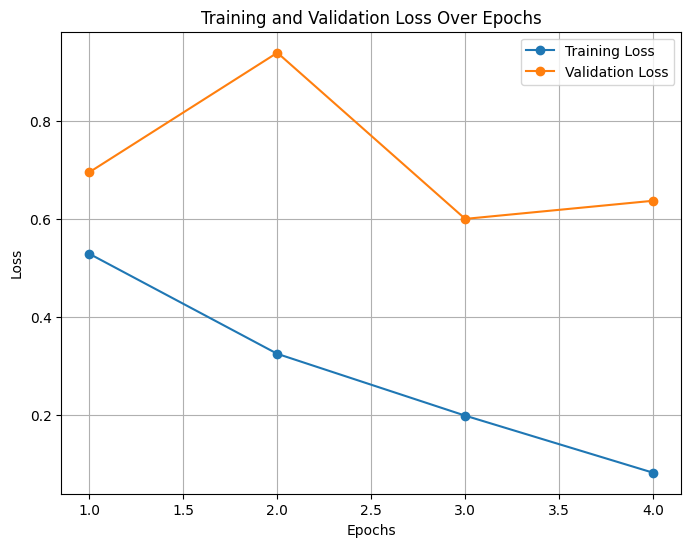

In [ ]:
# Extract the loss values for each epoch and display it in a figure
# BEGIN YOUR CODE HERE

import matplotlib.pyplot as plt
import numpy as np

# Extract loss values for training and validation from the history object
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Create an array, epochs, containing integers from 1 to the number of epochs (inclusive)
epochs = np.arange(1, len(train_loss) + 1)

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Add labels, title, grid, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



# END YOUR CODE HERE

In [ ]:
# BEGIN YOUR CODE HERE
# What is the loss and accuracy on the Testing dataset?
# Tip: instead of (x_test, y_test) we used in the lab last week, you can use
# directly test_ds which contains both data and labels
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
# When you print the output of the evaluate function, it will return both
# the loss and accuracy, maybe in a  format like [loss_value, accuracy_value]

import tensorflow as tf
import numpy as np

#Add/remove to_numpy to reshape object if error appears when running
y_test =y_test.to_numpy().reshape(-1, 1)

test_ds = tf.data.Dataset.from_tensor_slices((X_pad_test, y_test)).batch(32)

def evaluate_model(model, test_dataset, model_name):

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"{model_name} - Test Loss: {test_loss:.4f}")
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

# (Basic LSTM)
test_loss1, test_accuracy1 = evaluate_model(model1, test_ds, "Model 1 (Basic LSTM)")

# (Stacked LSTM)
test_loss2, test_accuracy2 = evaluate_model(model2, test_ds, "Model 2 (Stacked LSTM)")

# (Bidirectional GRU)
test_loss3, test_accuracy3 = evaluate_model(model3, test_ds, "Model 3 (Bidirectional GRU)")

print("\nSummary of Model Evaluation:")
print(f"Model 1 - Test Accuracy: {test_accuracy1:.4f}, Test Loss: {test_loss1:.4f}")
print(f"Model 2 - Test Accuracy: {test_accuracy2:.4f}, Test Loss: {test_loss2:.4f}")
print(f"Model 3 - Test Accuracy: {test_accuracy3:.4f}, Test Loss: {test_loss3:.4f}")

### End your code here

# What is the accuracy you get?
# If you get an accuracy of aprox 50%, what does it mean? Did your model learn?
# Try to modify the architecture; how you train the model or how much data you
# use to train it in order to improve the results.


125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.7823 - loss: 0.7834
Model 1 (Basic LSTM) - Test Loss: 0.6650
Model 1 (Basic LSTM) - Test Accuracy: 0.8150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8037 - loss: 0.6553
Model 2 (Stacked LSTM) - Test Loss: 0.8775
Model 2 (Stacked LSTM) - Test Accuracy: 0.6410
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7623 - loss: 0.8360
Model 3 (Bidirectional GRU) - Test Loss: 0.8091
Model 3 (Bidirectional GRU) - Test Accuracy: 0.7730

Summary of Model Evaluation:
Model 1 - Test Accuracy: 0.8150, Test Loss: 0.6650
Model 2 - Test Accuracy: 0.6410, Test Loss: 0.8775
Model 3 - Test Accuracy: 0.7730, Test Loss: 0.8091


Test the model with a random text


In [ ]:
test_samples = []

# Define a few sample reviews
review1 = "Petter Mattei's 'Love in the Time of Money' is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human nature. This is a movie that seems to be telling us what money, power and success do to people."
review2 = "The movie was terrible. The plot was predictable, the acting was stiff, and I couldn't wait for it to end. A waste of time."
review3 = "An incredible cinematic experience. The storytelling was brilliant, and the visuals were breathtaking. One of the best films I've seen in years."

# Append the reviews to the test_samples list
test_samples.append(review1)
test_samples.append(review2)
test_samples.append(review3)

# Preprocess the reviews
test_samples_preprocess = list(map(lambda x: preprocess(x, len(test_samples)), test_samples))
print(test_samples_preprocess)

# Convert to bigrams and trigrams
test_data_bigrams = trigrams[bigrams[test_samples_preprocess]]

# Vectorize the reviews using the trained model's vocabulary
test_data_pad = pad_sequences(
    sequences=vectorize_data(test_data_bigrams, vocab=trigram_model.wv.key_to_index),
    maxlen=input_length,
    padding='post'
)

# Get predictions for the reviews
predictions = model1.predict(test_data_pad)

# Print out the predicted sentiment for each review
for (t, p) in zip(test_samples, predictions):
    prediction_string = "positive"
    if p < 0.5:
        prediction_string = "negative"
    print(f"Predicted {prediction_string} with a probability of {p[0]:.4f} for review: {t}")


[['petter', 'mattei', 'love', 'time', 'money', 'visually', 'stun', 'film', 'watch', 'mr', 'mattei', 'offer', 'u', 'vivid', 'portrait', 'human', 'nature', 'movie', 'seem', 'tell', 'u', 'money', 'power', 'success', 'people'], ['movie', 'wa', 'terrible', 'plot', 'wa', 'predictable', 'act', 'wa', 'stiff', 'wait', 'end', 'waste', 'time'], ['incredible', 'cinematic', 'experience', 'storytelling', 'wa', 'brilliant', 'visuals', 'breathtaking', 'one', 'best', 'film', 'see', 'year']]
Vectorizing sentences... (done)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Predicted positive with a probability of 0.9985 for review: Petter Mattei's 'Love in the Time of Money' is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human nature. This is a movie that seems to be telling us what money, power and success do to people.
Predicted negative with a probability of 0.0135 for review: The movie was terrible. The plot was predictable, the acting was stiff, and I couldn't wait for it to 